In [1]:
! pip install transformers
# ! pip install pycaret

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import numpy as np
import pandas as pd
from transformers import AutoModel, BertTokenizerFast

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import classification_report

import torch.nn as nn

device = torch.device("cuda")

In [3]:
# Load Dataset
true_data = pd.read_csv('/home/alice/Desktop/Project_Placements/True.csv')
fake_data = pd.read_csv('/home/alice/Desktop/Project_Placements/Fake.csv')

In [5]:
fake_data.shape

(23481, 4)

In [6]:
true_data['target']=['True']*len(true_data)
fake_data['target']=['False']*len(fake_data)

data=true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])
print(data.shape)
data.head()

(44898, 5)


/tmp/ipykernel_619000/3689397673.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])


,title,text,subject,date,target
0,Lebanon's Hariri to arrive in France on Saturd...,PARIS (Reuters) - Lebanon s prime minister Saa...,worldnews,"November 16, 2017",True
1,NEW LOW: NYT’s And CBS Used FAKE NEWS To Smear...,Freedom Daily The Wounded Warrior Project (W...,politics,"Mar 28, 2017",False
2,Major Venezuelan opposition parties to boycott...,CARACAS (Reuters) - Three of Venezuela s large...,worldnews,"October 30, 2017",True
3,Veterans SHRED Trump For Exploiting Navy SEAL...,Trump s address to a joint session of Congress...,News,"March 1, 2017",False
4,"Trump, South Korea's Moon agree to boost defen...",WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,"September 22, 2017",True


In [7]:
data['label']=pd.get_dummies(data.target)['False']
data.head()

,title,text,subject,date,target,label
0,Lebanon's Hariri to arrive in France on Saturd...,PARIS (Reuters) - Lebanon s prime minister Saa...,worldnews,"November 16, 2017",True,0
1,NEW LOW: NYT’s And CBS Used FAKE NEWS To Smear...,Freedom Daily The Wounded Warrior Project (W...,politics,"Mar 28, 2017",False,1
2,Major Venezuelan opposition parties to boycott...,CARACAS (Reuters) - Three of Venezuela s large...,worldnews,"October 30, 2017",True,0
3,Veterans SHRED Trump For Exploiting Navy SEAL...,Trump s address to a joint session of Congress...,News,"March 1, 2017",False,1
4,"Trump, South Korea's Moon agree to boost defen...",WASHINGTON (Reuters) - U.S. President Donald T...,worldnews,"September 22, 2017",True,0


In [8]:
label_size=[data['label'].sum(),len(data['label'])-data['label'].sum()]
label_size

[23481, 21417]

In [10]:
len(data['label'])

44898

In [11]:
data['label'].sum()

23481

([<matplotlib.patches.Wedge at 0x7f164a83b790>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'TRue')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

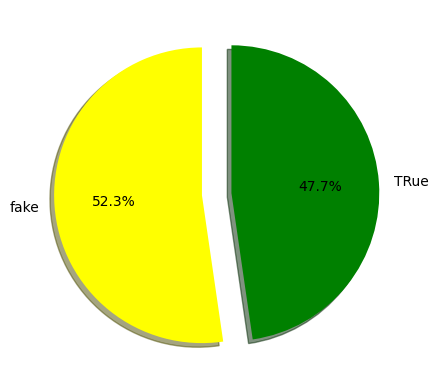

In [13]:
plt.pie(label_size, explode=[0.1,0.1],colors=['yellow','green'],startangle=90,shadow=True,labels=['fake','TRue'],autopct='%1.1f%%')

Train-Test-Split

In [9]:
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


In [21]:
train_labels

30979    1
21181    0
3390     0
29690    0
35631    0
        ..
41819    1
39111    1
31397    1
2966     1
25513    0
Name: label, Length: 31428, dtype: uint8

In [17]:
data

,title,text,subject,date,target,label
0,Germany withdraws diplomat from North Korea,WASHINGTON (Reuters) - Germany is withdrawing ...,worldnews,"November 30, 2017",True,0
1,Senate backs legislation to slap new sanctions...,WASHINGTON (Reuters) - The U.S. Senate voted o...,politicsNews,"June 14, 2017",True,0
2,"Taiwan suspends oil exports to North Korea, im...",TAIPEI (Reuters) - Taiwan has suspended refine...,worldnews,"September 19, 2017",True,0
3,ACTOR TIM ALLEN: Hillary Isn’t Capable Of Bein...,Megyn: What about Tim Allen? You re one of th...,left-news,"Aug 27, 2016",False,1
4,ILLINOIS: ENTIRE TEAM OF 8-Yr Old Kids Perform...,Every player on the Cahokia Quarterback Club f...,politics,"Sep 19, 2017",False,1
...,...,...,...,...,...,...
44893,Saudi Prince Arrested In LA For Sexual Assault...,Just a week after a Prince from Qatar was in h...,politics,"Sep 25, 2015",False,1
44894,"Exclusive: Koran, boots and scarves all that r...","MARAWI CITY, Philippines (Reuters) - Prayer ma...",worldnews,"October 27, 2017",True,0
44895,STUDY SHOWS UP TO 2.8 MILLION Non U.S. Citizen...,One California resident commented: Lots of ill...,left-news,"Jan 30, 2017",False,1
44896,Obama's not-so-secret admirer: Donald Trump,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"November 22, 2016",True,0


BERT Fine-Tuning

In [10]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [11]:
seq_len = [len(title.split()) for title in train_text]

seq_len

[15,
 13,
 8,
 11,
 9,
 14,
 15,
 15,
 14,
 10,
 16,
 11,
 11,
 11,
 10,
 13,
 11,
 17,
 10,
 6,
 16,
 9,
 13,
 14,
 10,
 9,
 12,
 11,
 9,
 18,
 8,
 33,
 11,
 14,
 14,
 14,
 13,
 10,
 12,
 15,
 8,
 13,
 18,
 12,
 9,
 13,
 15,
 21,
 11,
 19,
 13,
 9,
 10,
 13,
 14,
 9,
 9,
 16,
 23,
 12,
 9,
 8,
 13,
 13,
 10,
 10,
 12,
 5,
 25,
 15,
 13,
 10,
 9,
 9,
 8,
 12,
 9,
 8,
 24,
 20,
 10,
 9,
 8,
 11,
 10,
 11,
 13,
 9,
 12,
 9,
 13,
 20,
 11,
 26,
 11,
 10,
 11,
 12,
 17,
 12,
 13,
 12,
 14,
 14,
 13,
 14,
 13,
 13,
 17,
 10,
 10,
 14,
 11,
 10,
 18,
 17,
 15,
 13,
 14,
 11,
 12,
 11,
 18,
 12,
 15,
 12,
 10,
 21,
 9,
 17,
 15,
 8,
 15,
 13,
 11,
 14,
 10,
 10,
 11,
 20,
 17,
 10,
 15,
 21,
 12,
 12,
 12,
 12,
 13,
 11,
 11,
 17,
 15,
 14,
 11,
 12,
 12,
 9,
 10,
 9,
 13,
 10,
 15,
 16,
 6,
 8,
 13,
 14,
 9,
 19,
 10,
 7,
 14,
 16,
 8,
 14,
 9,
 11,
 19,
 14,
 16,
 9,
 13,
 8,
 11,
 9,
 10,
 10,
 19,
 13,
 11,
 9,
 15,
 13,
 10,
 10,
 15,
 12,
 16,
 13,
 8,
 14,
 9,
 15,
 14,
 11,
 9,
 10,
 

Text(0, 0.5, 'Number of Text')

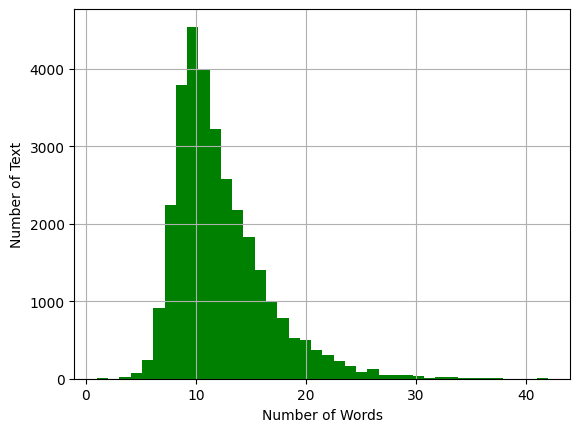

In [12]:
pd.Series(seq_len).hist(bins=40,color='green')
plt.xlabel('Number of Words')
plt.ylabel('Number of Text')

In [13]:
sample_data = ['Build fake news model','I am amazing','Learning bERT']

tokenized_sample = tokenizer.batch_encode_plus(sample_data,
                                               padding = True)

In [14]:
tokenized_sample

{'input_ids': [[101, 3857, 8275, 2739, 2944, 102], [101, 1045, 2572, 6429, 102, 0], [101, 4083, 14324, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 0, 0]]}

In [15]:
max_len = 17
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_len,
    pad_to_max_length= True,
    truncation= True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length= max_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_len,
    pad_to_max_length=True,
    truncation=True
)


/home/alice/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
train_Seq = torch.tensor(tokens_train['input_ids'])
train_mask= torch.tensor(tokens_train['attention_mask'])
train_y= torch.tensor(train_labels.tolist())

In [31]:
train_Seq

tensor([[ 101, 3422, 1024,  ..., 1011, 8398,  102],
        [ 101, 7327, 1005,  ..., 1005, 1047,  102],
        [ 101, 2317, 2160,  ...,    0,    0,    0],
        ...,
        [ 101, 4911, 1024,  ..., 2014, 2041,  102],
        [ 101, 4306, 1997,  ...,  102,    0,    0],
        [ 101, 8398, 4895,  ...,    0,    0,    0]])

In [32]:
train_mask

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [33]:
train_labels

30979    1
21181    0
3390     0
29690    0
35631    0
        ..
41819    1
39111    1
31397    1
2966     1
25513    0
Name: label, Length: 31428, dtype: uint8

In [17]:
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_Seq,train_mask,train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [19]:
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

Applying fine tuning by freezing the model layers and building my own model

In [20]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

Building upon base Model

In [24]:
class BERT_fined_Architecture(nn.Module):
    def __init__(self, bert):
        super(BERT_fined_Architecture, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,sent_id,mask):
        inp_pass = self.bert(sent_id,attention_mask=mask)['pooler_output']
        x = self.fc1(inp_pass)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [25]:
model = BERT_fined_Architecture(bert)

In [30]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)
CE_loss = nn.NLLLoss()
epochs = 2

/home/alice/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Defining Train and Evaluate function

In [31]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = CE_loss(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss = 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = CE_loss(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [40]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(10):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.342
Validation Loss: 0.294

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

Model Performance

In [41]:
# load weights of best model
path = '/home/alice/Desktop/Project_Placements/c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [42]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      3212
           1       0.92      0.88      0.90      3523

    accuracy                           0.90      6735
   macro avg       0.90      0.90      0.90      6735
weighted avg       0.90      0.90      0.90      6735



FAKE NEWS PREDICTOON

In [45]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers",                         # True
                    "India wins the world cup on 2020, what an increaible win it was!",                   #True   
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 0, 0])